In [1]:
# Line necessary to import agents in model, since the cwd of the notebook server is always the base path where you started the 
# server 
import sys
sys.path.append(".\sbp_toy_abm")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from calibrated_abm.model import FLCalibratedABM

%matplotlib inline

In [3]:
from mesa.batchrunner import BatchRunner

# Set batchrunner

Import data on farmers and farms

In [4]:
farmers_data = ".\data\FarmersData.xlsx"
farms_data = ".\data\FarmsData.xlsx"

### Define fixed parameters

Provide payments for SBP adoption

In [5]:
# Give payments in €/hectare, one entry for each year 
sbp_payments = [50.72, 50.72, 51.82]
payments = {"Sown Permanent Pasture": sbp_payments}

Provide costs for pastures

In [6]:
pastures_costs = {"Sown Permanent Pasture": {
                    "installation": [-722.97],
                    "maintenance": [0.00, -135.96, 0.00, -318.27, 0.00,
                                    -135.96, 0.00, -318.27, 0.00]
                          },
                  'Natural Pasture': {
                      "installation": [0.],
                      "maintenance": [-235.40, -210.18, -210.18, -210.18,
                                      -210.18, -235.40, -210.18, -210.18, 
                                      -210.18]
                      }
                  }

In [7]:
fixed_params = {
    "payments": payments,
    "pastures_costs": pastures_costs
}

### Define reporters to collect results

Model reporters

In [8]:
real_adoption_path = ".\data\FarmsDataValidation.xlsx"
real_adoption = pd.read_excel(real_adoption_path, index_col=0)

In [9]:
from sklearn.metrics import f1_score

def get_model_performance(model):
    """
    Function to calculated the F1 score of the model.
    """
    pred_adoption = []
    for agent in model.schedule.agents:
        pred_adoption.append(agent.farm.pasture_type.type)
    f1 = f1_score(real_adoption, pred_adoption, pos_label='Sown Permanent Pasture')
    return f1

In [10]:
def get_percentage_adopters(model):
    """
    Function to calculate the percentage of farmers that adopted SBP at the end of the simulation.
    """
    farmers_adopted = 0
    for farmer in model.schedule.agents:
        if farmer.farm.pasture_type.type == 'Sown Permanent Pasture':
            farmers_adopted += 1
    percentage_adopted = farmers_adopted / model.total_farmers * 100
    return percentage_adopted

In [11]:
model_to_collect = {
    "F1 score": get_model_performance,
    "Percentage of adopters": get_percentage_adopters
}

# 1st iteration

### Define variable parameters

#### Define values to test for each weight

In [12]:
values_weights = np.around(np.arange(-1, 1.01, 0.5), 2)

education_w = values_weights
pasture_surface_w = values_weights
legal_form_w = values_weights
percent_rented_land_w = values_weights

Generation of the list contatining all the possible combinations of weights in the right format to be inputted to the model

In [13]:
from itertools import product

combs = product(education_w, pasture_surface_w, legal_form_w, percent_rented_land_w)
weights_combs = []
while True:
    try:
        weights_combs.append(next(combs))
    except StopIteration:
        break

print(len(weights_combs))

625


In [14]:
variable_params = {"cf_weights": weights_combs}

## Run

In [15]:
param_sweep = BatchRunner(
    FLCalibratedABM,
    variable_parameters=variable_params,
    fixed_parameters=fixed_params,
    iterations=1,
    model_reporters=model_to_collect
)

In [16]:
param_sweep.run_all()

625it [18:28,  1.77s/it]


## Results

In [17]:
models_results = param_sweep.get_model_vars_dataframe()
models_results.head()

,cf_weights,Run,F1 score,Percentage of adopters,payments,pastures_costs
0,"(-1.0, -1.0, -1.0, -1.0)",0,0.0,0.0,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
1,"(-1.0, -1.0, -1.0, -0.5)",1,0.0,0.0,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
2,"(-1.0, -1.0, -1.0, 0.0)",2,0.0,0.0,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
3,"(-1.0, -1.0, -1.0, 0.5)",3,0.0,0.0,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
4,"(-1.0, -1.0, -1.0, 1.0)",4,0.0,0.0,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...


### F1 trend

In [18]:
models_results['F1 score'].describe()

count    625.000000
mean       0.205318
std        0.238383
min        0.000000
25%        0.000000
50%        0.090909
75%        0.400000
max        0.736842
Name: F1 score, dtype: float64

<AxesSubplot:>

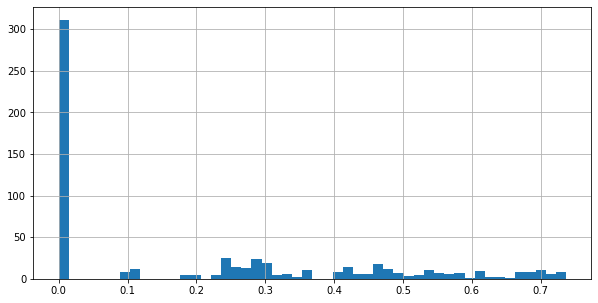

In [39]:
models_results['F1 score'].hist(bins=50, figsize=(10, 5))

<AxesSubplot:>

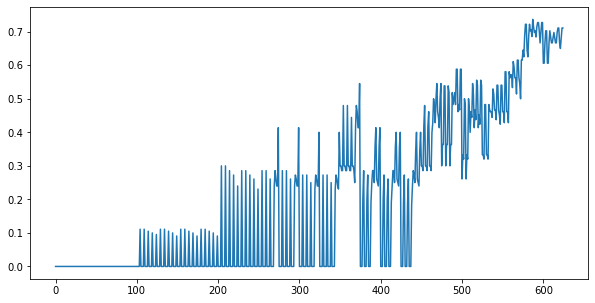

In [21]:
models_results['F1 score'].plot(figsize=(10, 5))

### Best model

In [22]:
best_f1_score = models_results['F1 score'].max()
best_models = models_results[['cf_weights', 'Percentage of adopters']][models_results['F1 score'] == best_f1_score]

print("Best F1 score:", str(best_f1_score))
print("")
print("Best models:")
print(best_models)      

Best F1 score: 0.7368421052631577

Best models:
               cf_weights  Percentage of adopters
587  (1.0, 0.5, 0.0, 0.0)                    70.0


# 2nd iteration

### Define variable parameters

#### Define values to test for each weight

In [54]:
education_w = np.around(np.arange(.5, 1.51, .25), 2)
pasture_surface_w = np.around(np.arange(0., 1.01, .25), 2)
legal_form_w = np.around(np.arange(-0.5, 0.501, .25), 2)
percent_rented_land_w = np.around(np.arange(-0.5, 0.501, .25), 2)

Generation of the list contatining all the possible combinations of weights in the right format to be inputted to the model

In [55]:
from itertools import product

combs = product(education_w, pasture_surface_w, legal_form_w, percent_rented_land_w)
weights_combs = []
while True:
    try:
        weights_combs.append(next(combs))
    except StopIteration:
        break

print(len(weights_combs))

625


In [29]:
variable_params_2 = {"cf_weights": weights_combs}

## Run

In [32]:
param_sweep_2 = BatchRunner(
    FLCalibratedABM,
    variable_parameters=variable_params_2,
    fixed_parameters=fixed_params,
    iterations=1,
    model_reporters=model_to_collect
)

In [33]:
param_sweep_2.run_all()

625it [11:33,  1.11s/it]


## Results

In [34]:
models_results_2 = param_sweep_2.get_model_vars_dataframe()
models_results_2.head()

,cf_weights,Run,F1 score,Percentage of adopters,payments,pastures_costs
0,"(0.5, 0.0, -0.5, -0.5)",0,0.000000,0.000000,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
1,"(0.5, 0.0, -0.5, -0.25)",1,0.000000,0.000000,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
2,"(0.5, 0.0, -0.5, 0.0)",2,0.000000,0.000000,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
3,"(0.5, 0.0, -0.5, 0.25)",3,0.000000,3.333333,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
4,"(0.5, 0.0, -0.5, 0.5)",4,0.190476,13.333333,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...


### F1 trend

In [35]:
models_results_2['F1 score'].describe()

count    625.000000
mean       0.595075
std        0.185448
min        0.000000
25%        0.533333
50%        0.666667
75%        0.727273
max        0.800000
Name: F1 score, dtype: float64

<AxesSubplot:>

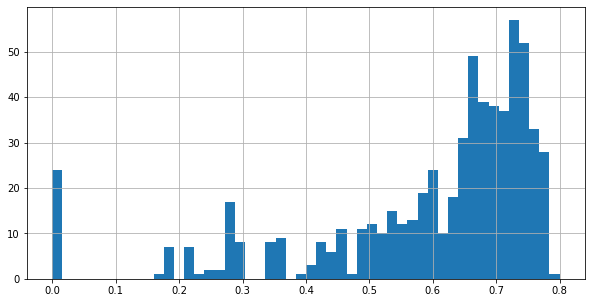

In [40]:
models_results_2['F1 score'].hist(bins=50, figsize=(10, 5))

<AxesSubplot:>

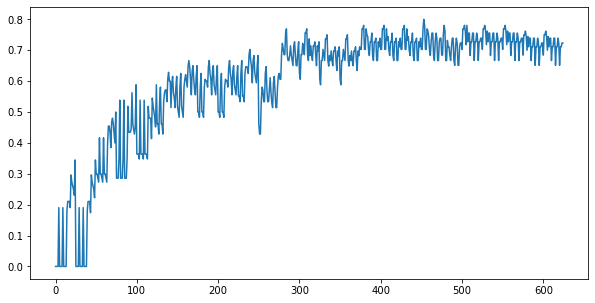

In [37]:
models_results_2['F1 score'].plot(figsize=(10, 5))

### Best model

In [41]:
best_f1_score_2 = models_results_2['F1 score'].max()
best_models_2 = models_results_2[['cf_weights', 'Percentage of adopters']][models_results_2['F1 score'] == best_f1_score_2]

print("Best F1 score:", str(best_f1_score_2))
print("")
print("Best models:")
print(best_models_2)       

Best F1 score: 0.7999999999999999

Best models:
                   cf_weights  Percentage of adopters
453  (1.25, 0.75, -0.5, 0.25)               76.666667


# 3nd iteration

### Define variable parameters

#### Define values to test for each weight

In [64]:
education_w = np.around(np.arange(1., 1.501, .125), 3)
pasture_surface_w = np.around(np.arange(0.5, 1.001, .125), 3)
legal_form_w = np.around(np.arange(-0.75, -0.249, .125), 3)
percent_rented_land_w = np.around(np.arange(0., 0.501, .125), 3)

Generation of the list contatining all the possible combinations of weights in the right format to be inputted to the model

In [65]:
from itertools import product

combs = product(education_w, pasture_surface_w, legal_form_w, percent_rented_land_w)
weights_combs = []
while True:
    try:
        weights_combs.append(next(combs))
    except StopIteration:
        break

print(len(weights_combs))

625


In [66]:
variable_params_3 = {"cf_weights": weights_combs}

## Run

In [67]:
param_sweep_3 = BatchRunner(
    FLCalibratedABM,
    variable_parameters=variable_params_3,
    fixed_parameters=fixed_params,
    iterations=1,
    model_reporters=model_to_collect
)

In [68]:
param_sweep_3.run_all()

625it [11:00,  1.06s/it]


## Results

In [74]:
models_results_3 = param_sweep_3.get_model_vars_dataframe()
models_results_3.head()

,cf_weights,Run,F1 score,Percentage of adopters,payments,pastures_costs
0,"(1.0, 0.5, -0.75, 0.0)",0,0.685714,60.000000,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
1,"(1.0, 0.5, -0.75, 0.125)",1,0.685714,60.000000,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
2,"(1.0, 0.5, -0.75, 0.25)",2,0.685714,60.000000,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
3,"(1.0, 0.5, -0.75, 0.375)",3,0.722222,63.333333,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
4,"(1.0, 0.5, -0.75, 0.5)",4,0.722222,63.333333,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...


### F1 trend

In [75]:
models_results_3['F1 score'].describe()

count    625.000000
mean       0.735695
std        0.034891
min        0.666667
25%        0.702703
50%        0.736842
75%        0.769231
max        0.800000
Name: F1 score, dtype: float64

<AxesSubplot:>

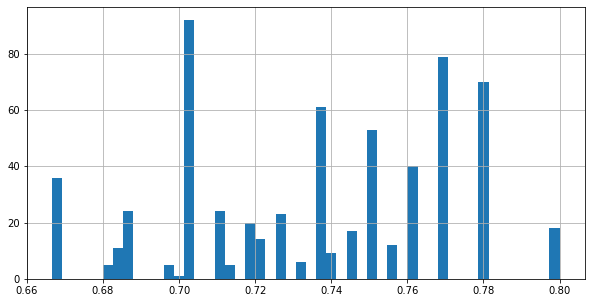

In [76]:
models_results_3['F1 score'].hist(bins=50, figsize=(10, 5))

<AxesSubplot:>

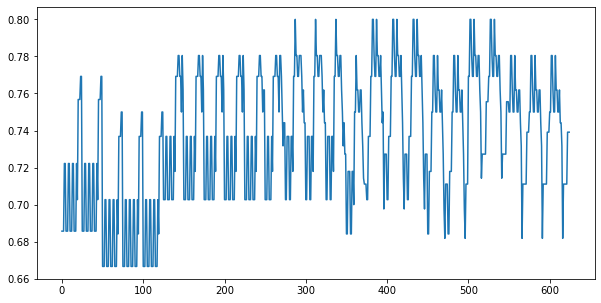

In [77]:
models_results_3['F1 score'].plot(figsize=(10, 5))

### Best model

In [78]:
best_f1_score_3 = models_results_3['F1 score'].max()
best_models_3 = models_results_3[['cf_weights', 'Percentage of adopters']][models_results_3['F1 score'] == best_f1_score_3]

print("Best F1 score:", str(best_f1_score_3))
print("")
print("Best models:")
print(best_models_3)

Best F1 score: 0.7999999999999999

Best models:
                        cf_weights  Percentage of adopters
287      (1.25, 0.625, -0.5, 0.25)               76.666667
312       (1.25, 0.75, -0.5, 0.25)               76.666667
337      (1.25, 0.875, -0.5, 0.25)               76.666667
382     (1.375, 0.5, -0.625, 0.25)               76.666667
383    (1.375, 0.5, -0.625, 0.375)               76.666667
387       (1.375, 0.5, -0.5, 0.25)               76.666667
407   (1.375, 0.625, -0.625, 0.25)               76.666667
408  (1.375, 0.625, -0.625, 0.375)               76.666667
412     (1.375, 0.625, -0.5, 0.25)               76.666667
432    (1.375, 0.75, -0.625, 0.25)               76.666667
433   (1.375, 0.75, -0.625, 0.375)               76.666667
437      (1.375, 0.75, -0.5, 0.25)               76.666667
502        (1.5, 0.5, -0.75, 0.25)               76.666667
503       (1.5, 0.5, -0.75, 0.375)               76.666667
507       (1.5, 0.5, -0.625, 0.25)               76.666667
527     

# 4th iteration

### Define variable parameters

#### Define values to test for each weight

In [111]:
education_w = np.around(np.arange(1.25, 1.501, .05), 3)
pasture_surface_w = np.around(np.arange(0.5, 0.876, .05), 3)
legal_form_w = np.around(np.arange(-0.75, -0.499, .05), 3)
percent_rented_land_w = np.around(np.arange(0.25, 0.375, .05), 3)

Generation of the list contatining all the possible combinations of weights in the right format to be inputted to the model

In [112]:
from itertools import product

combs = product(education_w, pasture_surface_w, legal_form_w, percent_rented_land_w)
weights_combs = []
while True:
    try:
        weights_combs.append(next(combs))
    except StopIteration:
        break

print(len(weights_combs))

864


In [113]:
variable_params_4 = {"cf_weights": weights_combs}

## Run

In [114]:
param_sweep_4 = BatchRunner(
    FLCalibratedABM,
    variable_parameters=variable_params_4,
    fixed_parameters=fixed_params,
    iterations=1,
    model_reporters=model_to_collect
)

In [115]:
param_sweep_4.run_all()

864it [15:27,  1.07s/it]


## Results

In [116]:
models_results_4 = param_sweep_4.get_model_vars_dataframe()
models_results_4.head()

,cf_weights,Run,F1 score,Percentage of adopters,payments,pastures_costs
0,"(1.25, 0.5, -0.75, 0.25)",0,0.702703,66.666667,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
1,"(1.25, 0.5, -0.75, 0.3)",1,0.736842,70.000000,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
2,"(1.25, 0.5, -0.75, 0.35)",2,0.736842,70.000000,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
3,"(1.25, 0.5, -0.7, 0.25)",3,0.702703,66.666667,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
4,"(1.25, 0.5, -0.7, 0.3)",4,0.736842,70.000000,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...


### F1 trend

In [117]:
models_results_4['F1 score'].describe()

count    864.000000
mean       0.774711
std        0.026198
min        0.702703
25%        0.736842
50%        0.780488
75%        0.800000
max        0.800000
Name: F1 score, dtype: float64

<AxesSubplot:>

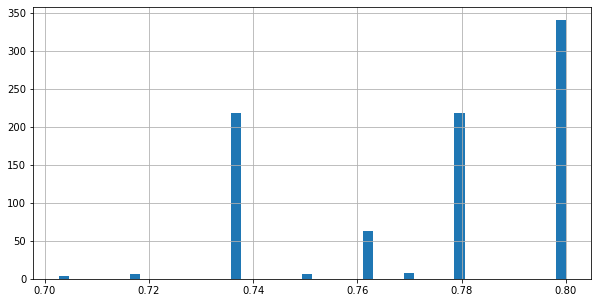

In [118]:
models_results_4['F1 score'].hist(bins=50, figsize=(10, 5))

<AxesSubplot:>

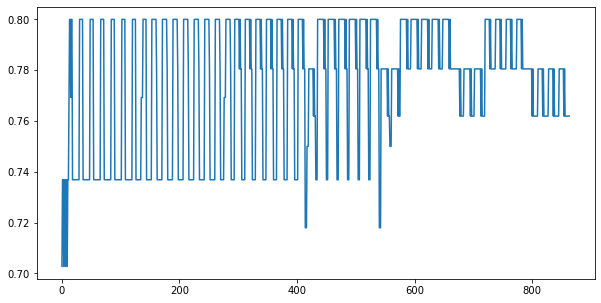

In [119]:
models_results_4['F1 score'].plot(figsize=(10, 5))

### Best model

In [120]:
best_f1_score_4 = models_results_4['F1 score'].max()
best_models_4 = models_results_4[['cf_weights', 'Percentage of adopters']][models_results_4['F1 score'] == best_f1_score_4]

print("Best F1 score:", str(best_f1_score_4))
print("")
print("Best models:")
print(best_models_4)

Best F1 score: 0.7999999999999999

Best models:
                    cf_weights  Percentage of adopters
13     (1.25, 0.5, -0.55, 0.3)               76.666667
14    (1.25, 0.5, -0.55, 0.35)               76.666667
16      (1.25, 0.5, -0.5, 0.3)               76.666667
17     (1.25, 0.5, -0.5, 0.35)               76.666667
30   (1.25, 0.55, -0.55, 0.25)               76.666667
..                         ...                     ...
778     (1.5, 0.65, -0.7, 0.3)               76.666667
779    (1.5, 0.65, -0.7, 0.35)               76.666667
780   (1.5, 0.65, -0.65, 0.25)               76.666667
781    (1.5, 0.65, -0.65, 0.3)               76.666667
783    (1.5, 0.65, -0.6, 0.25)               76.666667

[341 rows x 2 columns]


# Other analysis of results

In [121]:
models_results_2.loc[models_results_2['Percentage of adopters'] > 99]

,cf_weights,Run,F1 score,Percentage of adopters,payments,pastures_costs
494,"(1.25, 1.0, 0.25, 0.5)",494,0.723404,100.0,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
498,"(1.25, 1.0, 0.5, 0.25)",498,0.723404,100.0,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
499,"(1.25, 1.0, 0.5, 0.5)",499,0.723404,100.0,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
594,"(1.5, 0.75, 0.25, 0.5)",594,0.723404,100.0,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
598,"(1.5, 0.75, 0.5, 0.25)",598,0.723404,100.0,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
599,"(1.5, 0.75, 0.5, 0.5)",599,0.723404,100.0,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
619,"(1.5, 1.0, 0.25, 0.5)",619,0.723404,100.0,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
623,"(1.5, 1.0, 0.5, 0.25)",623,0.723404,100.0,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...
624,"(1.5, 1.0, 0.5, 0.5)",624,0.723404,100.0,"{'Sown Permanent Pasture': [50.72, 50.72, 51.82]}",{'Sown Permanent Pasture': {'installation': [-...


There is the same prediction as the logistic regression, but it is not the best result!